In [1]:
# import libraries
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import matplotlib.pyplot as plt

In [6]:
# load data
train_df = pd.read_pickle("../data/task1_LIWC_train.pickle")
val_df   = pd.read_pickle("../data/task1_LIWC_val.pickle")
print(train_df.columns)

Index(['user_id', 'text_id', 'text', 'timestamp', 'collection_phase',
       'is_words', 'valence', 'arousal', 'text_tokens', 'text_liwc_tokens',
       'ACHIEV', 'ADJ', 'ADVERB', 'AFFECT', 'AFFILIATION', 'ANGER', 'ANX',
       'ARTICLE', 'ASSENT', 'AUXVERB', 'BIO', 'BODY', 'CAUSE', 'CERTAIN',
       'COGPROC', 'COMPARE', 'CONJ', 'DEATH', 'DIFFER', 'DISCREP', 'DRIVES',
       'FAMILY', 'FEEL', 'FEMALE', 'FILLER', 'FOCUSFUTURE', 'FOCUSPAST',
       'FOCUSPRESENT', 'FRIEND', 'FUNCTION', 'HEALTH', 'HEAR', 'HOME', 'I',
       'INFORMAL', 'INGEST', 'INSIGHT', 'INTERROG', 'IPRON', 'LEISURE', 'MALE',
       'MONEY', 'MOTION', 'NEGATE', 'NEGEMO', 'NETSPEAK', 'NONFLU', 'NUMBER',
       'PERCEPT', 'POSEMO', 'POWER', 'PPRON', 'PREP', 'PRONOUN', 'QUANT',
       'RELATIV', 'RELIG', 'REWARD', 'RISK', 'SAD', 'SEE', 'SEXUAL', 'SHEHE',
       'SOCIAL', 'SPACE', 'SWEAR', 'TENTAT', 'THEY', 'TIME', 'VERB', 'WE',
       'WORK', 'YOU', 'POLITICAL', 'FEAR', 'JOY', 'PURPOSE', 'ORDER',
       'JUSTICE', 'num_t

In [ ]:
# Valence-related LIWC categories
VAL_POS = ["POSEMO", "JOY"]
VAL_NEG = ["NEGEMO", "SAD", "ANGER", "ANX", "FEAR"]

# Arousal-related LIWC categories (proxy)
ARO_HIGH=["ANGER", "ANX", "FEAR", "RISK", "DRIVES", "MOTION"]


In [8]:
def add_va_counts(df):
    df = df.copy()

    pos = df[VAL_POS].astype(float).sum(axis=1)
    neg = df[VAL_NEG].astype(float).sum(axis=1)
    high = df[ARO_HIGH].astype(float).sum(axis=1)

    df["valence_pos"] = pos
    df["valence_neg"] = neg
    df["arousal_high"] = high
    return df

train_df = add_va_counts(train_df)
val_df   = add_va_counts(val_df)


In [9]:
feat_cols = ["valence_pos", "valence_neg", "arousal_high", "num_tokens"]

X_train = train_df[feat_cols].astype(float).values
X_val   = val_df[feat_cols].astype(float).values

y_train = train_df[["valence", "arousal"]].astype(float).values
y_val   = val_df[["valence", "arousal"]].astype(float).values

In [10]:
reg = MultiOutputRegressor(Ridge(alpha=1.0, random_state=42))
reg.fit(X_train, y_train)

pred = reg.predict(X_val)

# MSE
mse_v = mean_squared_error(y_val[:, 0], pred[:, 0])
mse_a = mean_squared_error(y_val[:, 1], pred[:, 1])

# RMSE
rmse_v = np.sqrt(mse_v)
rmse_a = np.sqrt(mse_a)


print("\n==== LIWC count baseline (Train → Val) ====")
print(f"Valence  MSE:  {mse_v:.4f} | RMSE: {rmse_v:.4f}")
print(f"Arousal  MSE:  {mse_a:.4f} | RMSE: {rmse_a:.4f}")
print(f"Avg RMSE: {(rmse_v + rmse_a)/2:.4f}")



==== LIWC count baseline (Train → Val) ====
Valence  MSE:  1.3134 | RMSE: 1.1460
Arousal  MSE:  0.4641 | RMSE: 0.6812
Avg RMSE: 0.9136


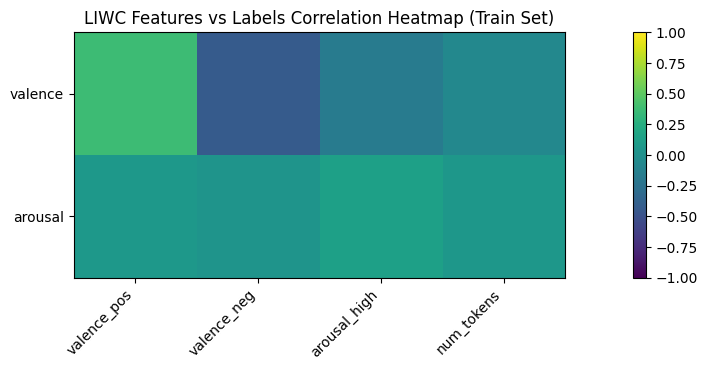

In [11]:
# compute correlations
corr_v = train_df[feat_cols].corrwith(train_df["valence"])
corr_a = train_df[feat_cols].corrwith(train_df["arousal"])

corr_mat = np.vstack([corr_v.values, corr_a.values])

# plot heatmap
plt.figure(figsize=(14, 3.8))
plt.imshow(corr_mat, vmin=-1, vmax=1)
plt.colorbar()

plt.xticks(range(len(feat_cols)), feat_cols, rotation=45, ha="right")
plt.yticks([0, 1], ["valence", "arousal"])

plt.title("LIWC Features vs Labels Correlation Heatmap (Train Set)")
plt.tight_layout()
plt.show()